# Input Data Preparation

In [0]:
from glob import glob
from imageio import imread
from tqdm import tqdm
import tensorflow as tf
import json
import os.path as osp
import numpy as np
import numpy.random as npr
import cv2
import os
from tensorflow.contrib.learn.python.learn.datasets import base

In [0]:
class DetectionDataset(object):
    def __init__(self, data_type, class_names, images, gt_box_sets):
        
        self._num_samples = len(images)
        self._data_type = data_type
        
        self._class_names = class_names
        self._num_classes = len(self._class_names)
        self._images =images
        self._gt_box_sets = gt_box_sets

        self._image_shapes = np.asarray([img.shape for img in images], dtype=np.float32)
        
        self._augment = True
        
        self._indices = None        
        self._cursor = 0
        self._epoch_count = 0
    
    @property
    def class_names(self):
        return self._class_names
    
    @property
    def num_classes(self):
        return self._num_classes
    
    @property
    def images(self):
        return self._images

    @property
    def gt_box_sets(self):
        return self._gt_box_sets
    
    def set_augment(self, augment):
        self._augment = augment

    def get_image(self, index):
        return self._images[index]

    def get_gt_box_set(self, index):
        return self._gt_box_sets[index]

    def get_image_shape(self, index):
        return self._image_shapes[index]
    
    @property
    def num_samples(self):
        return self._num_samples

    @property
    def num_epochs(self):
        return self._epoch_count
    
    def _start_next_epoch(self, shuffle):
        is_initial = self._indices is None

        self._indices = npr.permutation(self._num_samples) if shuffle else np.arange(self._num_samples)
        self._cursor = 0
        if not is_initial:
            self._epoch_count += 1
            
    def next_batch(self, batch_size, shuffle=True, get_idx=False):
        if self._indices is None:
            self._start_next_epoch(shuffle)
        
        stride = min(batch_size, self._num_samples - self._cursor)
        indices = self._indices[self._cursor:self._cursor + stride]
        self._cursor += stride
                
        while len(indices) < batch_size:
            self._start_next_epoch(shuffle)
            stride = min(batch_size, self.num_samples - self._cursor)
            indices = np.concatenate([indices, self._indices[self._cursor:self._cursor + stride]])
            self._cursor += stride
        
        batch_images, batch_gt_box_sets = self._images[indices], self._gt_box_sets[indices]
        
        if batch_size == 1:
            batch_images = np.asarray([batch_images[0]], dtype=np.float32)
            batch_gt_box_sets = np.asarray([batch_gt_box_sets[0]], dtype=np.float32)

        if get_idx:
            return batch_images, batch_gt_box_sets, indices
        else:        
            return batch_images, batch_gt_box_sets
    
    def get_batch(self, idx):
        indices = [idx]
        batch_images, batch_gt_box_sets = self._images[indices], self._gt_box_sets[indices]
        batch_images = np.asarray([batch_images[0]], dtype=np.float32)
        batch_gt_box_sets = np.asarray([batch_gt_box_sets[0]], dtype=np.float32)

        return batch_images, batch_gt_box_sets


def read_data(data_dir, load_rate=1.0):
    # Get a list of the class names.
    class_names = []

    with open(osp.join(data_dir, 'classes.json'), 'r') as f:
        class_dict = json.load(f)
        
    for i in sorted(class_dict.keys(), key=int):
        class_names.append(class_dict[str(i)])

    # Load image and annotation files.
    images, ground_truth_box_sets = [], []

    image_files = sorted(glob(osp.join(data_dir, 'images/*.jpg')))
    annotation_files = sorted(glob(osp.join(data_dir, 'annotations/*.anno')))
    
    num_samples = len(image_files)
    if load_rate < 1:
        num_samples = int(num_samples * load_rate)
        image_files = image_files[:num_samples]
        annotation_files = annotation_files[:num_samples]
    
    assert len(image_files) == len(annotation_files)

    for img_fp, anno_fp in zip(tqdm(image_files), annotation_files):
        img = imread(img_fp)
        if len(img.shape) < 3:
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

        images.append(np.asarray(img / 255, dtype=np.float32))

        with open(anno_fp, 'r') as f:
            anno = json.load(f)
            
        box_set = []
        for class_names, boxes in anno.items():
            box_set.extend([box + [class_names.index(class_names)] for box in boxes])
        ground_truth_box_sets.append(np.asarray(box_set, dtype=np.float32))
    
    return [class_names], images, ground_truth_box_sets, num_samples
    
    
def read_train_data_sets(data_dir, load_rate=1.0):
    class_names, train_images, train_gt_box_sets, data_size = read_data(data_dir + 'train', load_rate)
    train_size = int(data_size * (1 - 0.2))
    
    if train_size <= 0:
        print('No data to read')
        return base.Datasets(train=None, validation=None, test=None)
            
    validation_images = np.array(train_images[train_size:])
    validation_gt_box_sets = np.array(train_gt_box_sets[train_size:])
    train_images = np.array(train_images[:train_size])
    train_gt_box_sets = np.array(train_gt_box_sets[:train_size])
    
    train = DetectionDataset('train', class_names, train_images, train_gt_box_sets)
    validation = DetectionDataset('validation', class_names, validation_images, validation_gt_box_sets)
        
    return base.Datasets(train=train, validation=validation, test=None)

def read_test_data_sets(data_dir, load_rate=1.0):
    class_names, test_images, test_gt_box_sets, data_size = read_data(data_dir + 'test', load_rate)

    try:
        test_images = np.array(test_images)
    except:
        print('No data to read')
        return base.Datasets(train=None, validation=None, test=None)
    
    test_gt_box_sets = np.array(test_gt_box_sets)
    
    test = DetectionDataset('test', class_names, test_images, test_gt_box_sets)
    
    return base.Datasets(train=None, validation=None, test=test)

def read_data_sets(data_dir, load_rate=1.0):
    class_names, train_images, train_gt_box_sets, data_size = read_data(data_dir + 'train', load_rate)
    train_size = int(data_size * (1 - 0.2))
    
    if train_size <= 0:
        print('No data to read')
        return base.Datasets(train=None, validation=None, test=None)
    
    validation_images = np.array(train_images[train_size:])
    validation_gt_box_sets = np.array(train_gt_box_sets[train_size:])
    train_images = np.array(train_images[:train_size])
    train_gt_box_sets = np.array(train_gt_box_sets[:train_size])
    
    class_names, test_images, test_gt_box_sets, data_size = read_data(data_dir + 'test', load_rate)
    
    try:
        test_images = np.array(test_images)
    except:
        print('No data to read')
        return base.Datasets(train=None, validation=None, test=None)
    
    test_gt_box_sets = np.array(test_gt_box_sets)
    test = DetectionDataset('test', class_names, test_images, test_gt_box_sets)
    
    train = DetectionDataset('train', class_names, train_images, train_gt_box_sets)
    validation = DetectionDataset('validation', class_names, validation_images, validation_gt_box_sets)
    test = DetectionDataset('test', class_names, test_images, test_gt_box_sets)
    
    return base.Datasets(train=train, validation=validation, test=test)


In [0]:
loadtest1 = read_train_data_sets('./FDDB/', load_rate=0.2)
loadtest2 = read_test_data_sets('./FDDB/', load_rate=0.2)

100%|██████████| 44/44 [00:00<00:00, 183.71it/s]


# 1. Train

<br />
## Global Variables

In [0]:
is_train = True

<br />
# 1.1 Load Data

In [0]:
data1 = read_train_data_sets('../test_data/FDDB/', load_rate=0.2)
data2 = read_test_data_sets('../test_data/FDDB/', load_rate=1.0)
data_train = data1.train
data_test = data2.test

num_classes = data_train.num_classes

100%|██████████| 220/220 [00:01<00:00, 177.56it/s]


In [0]:
tf_input_image = tf.placeholder(tf.float32, shape=[1, None, None, 3])
tf_gt_boxes = tf.placeholder(tf.float32, shape=[1, None, 5])

<br />
# 1.2 Hyperparameters

In [0]:
class ModelHyperParameter():

    #----------------------------------------------------------------------
    # Train
    #----------------------------------------------------------------------
    # Training loop
    batch_size = 1
    num_epochs = 200

    if is_train:
        num_batches_per_epoch = data_train.num_samples // batch_size

    #----------------------------------------------------------------------
    # Train Backpropagation: Gradient descent optimization 
    #----------------------------------------------------------------------
    # momentum
    momentum = 0.9       

    # decaying learning rate
    init_learning_rate = 0.01     # default learning rate (epsilon)
    patience_of_no_improvement_epochs = 30
    learning_rate_decay = 0.1
    lower_bound_learning_rate = 1e-8
    current_learning_rate_value = 0.001


    #----------------------------------------------------------------------
    # Validation & Testing
    #----------------------------------------------------------------------

    # Validation & Testing
    num_evaluations = 500  # 100

    # Evaluator: check is better score
    is_better_score_threshold = 1e-4


    #----------------------------------------------------------------------
    # RPN Model
    #----------------------------------------------------------------------
    rpn_channels = 512

    # stride for images
    # 이미지 내 gride 계산 시, 한 grid에 total stride = 16 pixel 씩 되도록 등분함
    total_stride = 16

    # Anchor box generation
    anchor_base_size = 16          # initial size = 16
    anchor_scales = [8, 16, 24]     #  2 scales x 3 ratios = 6 anchor boxes for each grid
    anchor_ratios = [0.5, 1, 2]   
    num_anchors_per_grid = 9       # |anchor_scales| x |anchor_ratios|

    # Anchor box's y true targeting & batch sampling
    anchor_positive_rate = 0.5
    anchor_batch_size = 128
    anchor_positive_threshold = 0.7
    anchor_negative_threshold = 0.3

    # NMS (non maximum suppression)
    nms_top_k = 2000
    nms_iou_threshold = 0.7


    #----------------------------------------------------------------------
    # FRCNN Model
    #----------------------------------------------------------------------
    # Proposal box's y true targeting & batch sampling
    proposal_positive_rate = 0.25
    proposal_batch_size = 128
    proposal_positive_threshold = 0.7
    proposal_negative_threshold = 0.5


    # ROI pooling 
    # from Fast R-CNN, speical version of spatial pyramid pooling from SPP-Net)
    # R-CNN -> SPP-Net -> Fast R-CNN -> Faster R-CNN
    roi_pool_size = 7
    
_hp = ModelHyperParameter()

<br />
# 1.3 Build ConvNet Model (VGG16)

In [0]:
info = ''  # log printing variable

#### layer building functions

In [0]:
def input_feature_extraction_only(input):    
    x = input    
    global info
    info = ' Inputs'
    info += '\n   {:12s}: {:17s}  {}'.format('x', str(x.shape), 'input images')
    return x

def output_labels(out_channel):
    y = tf.placeholder(tf.float32, [None, out_channel])
    global info
    info += '\n   {:12s}: {:17s}  {}\n\n Feature Extraction'.format('y', str(y.shape), 'target value (answer label)')
    return y

In [0]:
def conv(name, inputs, filter_size, stride, num_filters, padding='SAME', is_print=True):
    bias=0.0
    
    in_channel = int(inputs.get_shape()[-1])
    out_channel = num_filters

    weights = tf.get_variable(name=name + '_weights',
                shape=[filter_size, filter_size, in_channel, out_channel],
                dtype=tf.float32,
                initializer=tf.contrib.layers.xavier_initializer())
    
    biases = tf.get_variable(name + '_biases',
                [out_channel], tf.float32,
                tf.constant_initializer(value=bias))

    conv = tf.nn.conv2d(inputs, weights, 
                strides=[1, stride, stride, 1],
                padding=padding) + bias

    conv = tf.nn.relu(conv)  # activation (non-linearizing)

    if is_print:
        global info
        # skip if this is an inception layer's sub layer
        info += '\n   {:12s}: {:17s} -> {:17s}'.format(
                        name,  str(inputs.shape), str(conv.shape) )        
    return conv

In [0]:
def pool(name, inputs, filter_size, stride, padding='SAME', is_print=True):
    pool = tf.nn.max_pool(inputs, 
               ksize = [1, filter_size, filter_size, 1],
               strides = [1,stride,stride,1], padding=padding)

    if is_print:
        global info
        # skip if this is an inception layer's sub layer
        info += '\n   {:12s}: {:17s} -> {:17s}'.format(
                        name,  str(inputs.shape), str(pool.shape) )
    return pool

In [0]:
def fc(name, inputs, output_size, is_print=True):
    bias=0.1
    in_dim = int(inputs.get_shape()[-1])
    out_dim = output_size

    weights = tf.get_variable(name=name + '_weights',
                shape=[in_dim, out_dim],
                initializer=tf.contrib.layers.xavier_initializer())

    biases = tf.get_variable(name + '_biases',
                [out_dim], tf.float32,
                tf.constant_initializer(value=bias))

    fc = tf.matmul(inputs, weights) + biases
    fc = tf.nn.relu(fc)  # activation

    # The probability of keeping each unit for dropout layers
    keep_prob_value = tf.cond(tf.cast(is_train, tf.bool),
                              lambda: train_dropout_rate,
                              lambda: 1.0)

    fc = tf.nn.dropout(fc, keep_prob=keep_prob_value)

    if is_print:
        global info
        info += '\n   {:12s}: {:17s} -> {:17s}'.format(
                       name,  str(inputs.shape), str(fc.shape) )        
    return fc

In [0]:
def fc_last(name, inputs, output_size, is_print=True):
    bias=0.0 
    in_dim = int(inputs.get_shape()[-1])
    out_dim = output_size

    weights = tf.get_variable(name=name + '_weights',
                shape=[in_dim, out_dim],
                initializer=tf.contrib.layers.xavier_initializer())

    biases = tf.get_variable(name + '_biases',
                [out_dim], tf.float32,
                tf.constant_initializer(value=bias))

    logits = tf.matmul(inputs, weights) + biases

    if is_print:
        global info
        info += '\n   {:12s}: {:17s} -> {:17s}'.format(
                        name,  str(inputs.shape), str(logits.shape) )        
    return logits

In [0]:
def logits_to_softmax(name, inputs):
    # hypothesis (prediction) of target value y
    y_hat = tf.nn.softmax(inputs)  
    
    global info
    info += '\n\n Output\n   {:12s}: {:8s}hypothesis (prediction) of target value y'.format(name, str(y_hat.shape))

    return y_hat

#### network layers

In [0]:
class ConvModel:
    # input
    x = None
    y = None

    # feature extraction
    conv1 = None
    conv2 = None
    pool2 = None

    conv3 = None
    conv4 = None
    pool4 = None

    conv5 = None
    conv6 = None
    conv7 = None
    pool7 = None

    conv8 = None
    conv9 = None
    conv10 = None
    pool10 = None

    conv11 = None
    conv12 = None
    conv13 = None
    pool13 = None
    
    output_feature_map = None

    #flat = None

    # classification
    #fc14 = None
    #fc15 = None
    #logits = None

    # hypothesis (prediction) of target value y
    #y_prediction = None
    
m_conv = ConvModel()

In [0]:
tf_input_image = tf.placeholder(tf.float32, shape=[1, None, None, 3])
m_conv.input_image = input_feature_extraction_only(tf_input_image)

m_conv.conv1  = conv('conv1' , m_conv.input_image, 3, 1, 64 )
m_conv.conv2  = conv('conv2' , m_conv.conv1 , 3, 1, 64 )
m_conv.pool2  = pool('pool2' , m_conv.conv2 , 2, 2)            

m_conv.conv3  = conv('conv3' , m_conv.pool2 , 3, 1, 128)
m_conv.conv4  = conv('conv4' , m_conv.conv3 , 3, 1, 128)
m_conv.pool4  = pool('pool4' , m_conv.conv4 , 2, 2)

m_conv.conv5  = conv('conv5' , m_conv.pool4 , 3, 1, 256)
m_conv.conv6  = conv('conv6' , m_conv.conv5 , 3, 1, 256)
m_conv.conv7  = conv('conv7' , m_conv.conv6 , 3, 1, 256)
m_conv.pool7  = pool('pool7' , m_conv.conv7 , 2, 2)

m_conv.conv8  = conv('conv8' , m_conv.pool7 , 3, 1, 512)
m_conv.conv9  = conv('conv9' , m_conv.conv8 , 3, 1, 512)
m_conv.conv10 = conv('conv10', m_conv.conv9 , 3, 1, 512)
m_conv.pool10 = pool('pool10', m_conv.conv10, 2, 2)

m_conv.conv11 = conv('conv11', m_conv.pool10, 3, 1, 512)
m_conv.conv12 = conv('conv12', m_conv.conv11, 3, 1, 512)
m_conv.conv13 = conv('conv13', m_conv.conv12, 3, 1, 512)

m_conv.output_feature_map = m_conv.conv13

In [0]:
print(info)

 Inputs
   x           : (1, ?, ?, 3)       input images
   conv1       : (1, ?, ?, 3)      -> (1, ?, ?, 64)    
   conv2       : (1, ?, ?, 64)     -> (1, ?, ?, 64)    
   pool2       : (1, ?, ?, 64)     -> (1, ?, ?, 64)    
   conv3       : (1, ?, ?, 64)     -> (1, ?, ?, 128)   
   conv4       : (1, ?, ?, 128)    -> (1, ?, ?, 128)   
   pool4       : (1, ?, ?, 128)    -> (1, ?, ?, 128)   
   conv5       : (1, ?, ?, 128)    -> (1, ?, ?, 256)   
   conv6       : (1, ?, ?, 256)    -> (1, ?, ?, 256)   
   conv7       : (1, ?, ?, 256)    -> (1, ?, ?, 256)   
   pool7       : (1, ?, ?, 256)    -> (1, ?, ?, 256)   
   conv8       : (1, ?, ?, 256)    -> (1, ?, ?, 512)   
   conv9       : (1, ?, ?, 512)    -> (1, ?, ?, 512)   
   conv10      : (1, ?, ?, 512)    -> (1, ?, ?, 512)   
   pool10      : (1, ?, ?, 512)    -> (1, ?, ?, 512)   
   conv11      : (1, ?, ?, 512)    -> (1, ?, ?, 512)   
   conv12      : (1, ?, ?, 512)    -> (1, ?, ?, 512)   
   conv13      : (1, ?, ?, 512)    -> (1, ?, ?,

<br />
# 1.4 Build RPN Model

### 1.4.1 RPN Preprocessing 1 - Anchorbox Generation

In [0]:
current_image_h = 0
current_image_w = 0
num_grids_h = 0
num_grids_w = 0
num_grids = 0

In [0]:
def anchorbox_generation():
    input_image = tf_input_image
    image_shape = tf.shape(input_image)
    
    global current_image_h
    global current_image_w
    global num_grids_h
    global num_grids_w
    global num_grids

    # Calculate the number of grid cells.
    current_image_h = image_shape[1]
    current_image_w = image_shape[2]

    # Calculate the number of grid cells.
    num_grids_h = tf.to_int32(tf.ceil(current_image_h / np.float32(_hp.total_stride)))
    num_grids_w = tf.to_int32(tf.ceil(current_image_w / np.float32(_hp.total_stride)))
    num_grids = num_grids_h * num_grids_w

    # Create a base anchor.
    base_anchor = np.array([0, 0, _hp.anchor_base_size - 1, _hp.anchor_base_size - 1])  # [4]

    # Expand anchors by ratios.
    anchors = expand_anchors_by_ratios(base_anchor, _hp.anchor_ratios)  # [num_ratios, 4]

    # Expand anchors by scales.
    anchors = np.vstack(  # [num_ratios * num_scales, 4]
        [expand_anchors_by_scales(anchors[i, :], _hp.anchor_scales) for i in range(anchors.shape[0])]
    )

    # Expand anchors by shifts.
    _hp.num_anchors_per_grid = anchors.shape[0]
    anchors = tf.constant(anchors.reshape((1, _hp.num_anchors_per_grid, 4)), dtype=tf.int32)  # [1, num_anchors_per_grid, 4]
    # [1, num_anchors_per_grid, 4]

    shift_x, shift_y = tf.meshgrid(
        tf.range(num_grids_w) * _hp.total_stride, 
        tf.range(num_grids_h) * _hp.total_stride
    )
    shift_x, shift_y = tf.reshape(shift_x, (-1,)), tf.reshape(shift_y, (-1,))  # [num_grids], [num_grids]
    shifts = tf.transpose(tf.stack([shift_x, shift_y, shift_x, shift_y]))  # [num_grids, 4]
    shifts = tf.transpose(tf.reshape(shifts, shape=[1, num_grids, 4]), perm=(1, 0, 2))  # [num_grids, 1, 4]

    anchors = tf.add(anchors, shifts)  # [num_grids, num_anchors_per_grid, 4]
    anchors = tf.reshape(anchors, (-1, 4))  # [num_anchors, 4], where num_grids * num_anchors_per_grid = num_anchors

    return tf.cast(anchors, dtype=tf.float32)

def expand_anchors_by_scales(anchor, scales):
    """
    Enumerate a set of anchors for each scale wrt an anchor.
    """
    scales = np.array(scales)
    w, h, x_ctr, y_ctr = get_whxy_format(anchor)
    ws = w * scales
    hs = h * scales
    anchors = get_anchor_format(ws, hs, x_ctr, y_ctr)
    return anchors

def expand_anchors_by_ratios(anchor, ratios):
    """
    Enumerate a set of anchors for each aspect ratio wrt an anchor.
    """
    ratios = np.array(ratios)
    w, h, x_ctr, y_ctr = get_whxy_format(anchor)
    size = w * h
    size_ratios = size / ratios
    ws = np.round(np.sqrt(size_ratios))
    hs = np.round(ws * ratios)
    anchors = get_anchor_format(ws, hs, x_ctr, y_ctr)
    return anchors

def get_whxy_format(anchor):
    """
    Return width, height, x center, and y center for an anchor (window).
    """
    w = anchor[2] - anchor[0] + 1
    h = anchor[3] - anchor[1] + 1
    x_ctr = anchor[0] + 0.5 * (w - 1)
    y_ctr = anchor[1] + 0.5 * (h - 1)
    return w, h, x_ctr, y_ctr

def get_anchor_format(ws, hs, x_ctr, y_ctr):
    """
    Given a vector of widths (ws) and heights (hs) around a center (x_ctr, y_ctr), output a set of anchors (windows).
    """
    ws = ws[:, np.newaxis]
    hs = hs[:, np.newaxis]
    anchors = np.hstack(
        (x_ctr - 0.5 * (ws - 1), y_ctr - 0.5 * (hs - 1), x_ctr + 0.5 * (ws - 1), y_ctr + 0.5 * (hs - 1))
    )
    return anchors

In [0]:
init_anchor_boxes = anchorbox_generation()

#### (test) visualization anchor box

In [0]:
graph = tf.get_default_graph()
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(graph=graph, config=config) 
sess.run(tf.global_variables_initializer())    # initialize all weights

In [0]:
batch_image, batch_gt_boxes = data_train.get_batch(idx=3)

In [0]:
anchor_boxes, image_h, image_w, n_grids_h, n_grids_w, n_grids = sess.run([
    init_anchor_boxes, 
    current_image_h, current_image_w,
    num_grids_h, num_grids_w, num_grids],
               feed_dict={tf_input_image: batch_image})

In [0]:
print('Image shape      : {} x {}'.format(image_h, image_w))
print('Total stride     : {}'.format(_hp.total_stride))
print('H grids          : {} / {} = {}'.format(image_h, _hp.total_stride, n_grids_h))
print('W grids          : {} / {} = {}'.format(image_w, _hp.total_stride, n_grids_w))
print('Number of grids  : {} x {} = {}'.format(n_grids_h, n_grids_w, n_grids))
print('Number of anchors: {} x {} = {}'.format(n_grids, _hp.num_anchors_per_grid, anchor_boxes.shape[0]))

Image shape      : 316 x 450
Total stride     : 16
H grids          : 316 / 16 = 20
W grids          : 450 / 16 = 29
Number of grids  : 20 x 29 = 580
Number of anchors: 580 x 9 = 5220


# anchor boxes for one grid

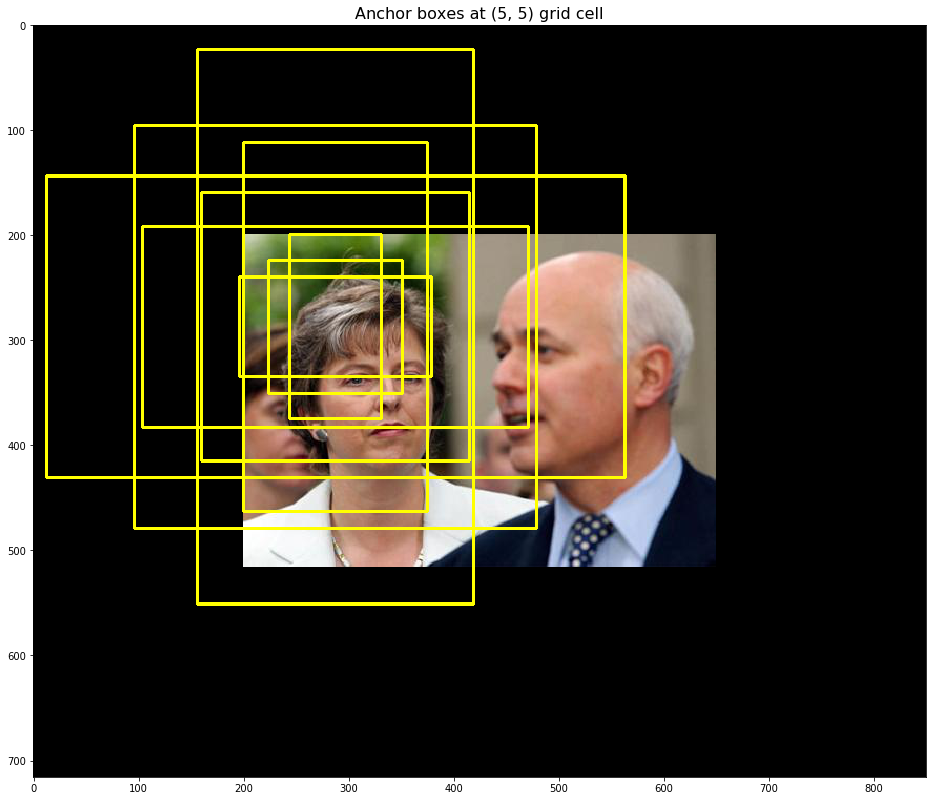

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
        
# FIXME
MARGIN = 200
GRID_IDX = (5, 5)
SHOW_ALL = False
PRINT_BOX_INFO = False

K = len(_hp.anchor_scales) * len(_hp.anchor_ratios)
img_h, img_w = batch_image.shape[1:3]

img_with_margin = np.zeros((img_h + MARGIN * 2, img_w + MARGIN * 2, 3)).astype(np.uint8)
img_with_margin[
    MARGIN:MARGIN + img_h, MARGIN:MARGIN + img_w, :
] = np.asarray(batch_image[0] * 255, dtype=np.uint8)

for idx, box in enumerate(anchor_boxes):
    if not SHOW_ALL and idx // K != GRID_IDX[0] * n_grids_w + GRID_IDX[1]:
        continue
    box = box + MARGIN
    cv2.rectangle(img_with_margin, (box[0], box[1]), (box[2], box[3]), color=(255, 255, 0), thickness=2)
    if PRINT_BOX_INFO:
        print('[Box # {}] Shape: ({:3}, {:3}) -> Size: {:6d},  Scale: {:.3f}'.format(
            idx % K, int(box[2] - box[0]), int(box[3] - box[1]),
            int((box[2] - box[0]) * (box[3] - box[1])), (box[2] - box[0]) / (box[3] - box[1])
        ))

plt.figure(figsize=(16, 16))
plt.title('Anchor boxes at {} grid cell'.format(GRID_IDX), fontdict={'fontsize': 16})
plt.imshow(img_with_margin)
plt.show()

all anchor boxes

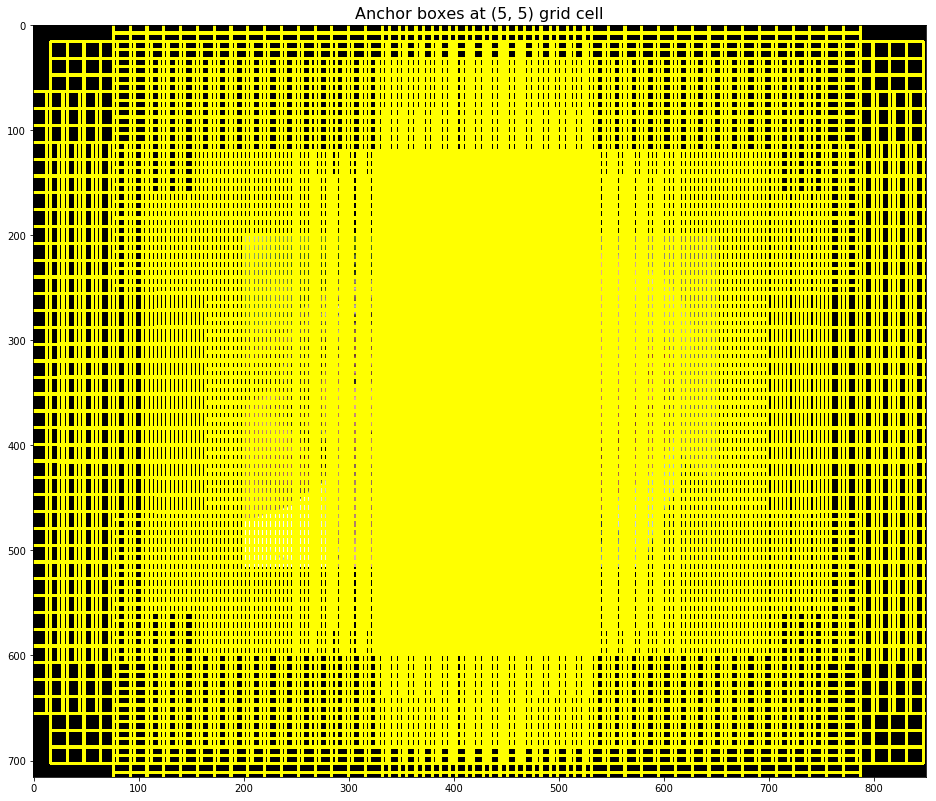

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
        
# FIXME
MARGIN = 200
GRID_IDX = (5, 5)
SHOW_ALL = True
PRINT_BOX_INFO = False

K = len(_hp.anchor_scales) * len(_hp.anchor_ratios)
img_h, img_w = batch_image.shape[1:3]

img_with_margin = np.zeros((img_h + MARGIN * 2, img_w + MARGIN * 2, 3)).astype(np.uint8)
img_with_margin[
    MARGIN:MARGIN + img_h, MARGIN:MARGIN + img_w, :
] = np.asarray(batch_image[0] * 255, dtype=np.uint8)

for idx, box in enumerate(anchor_boxes):
    if not SHOW_ALL and idx // K != GRID_IDX[0] * n_grids_w + GRID_IDX[1]:
        continue
    box = box + MARGIN
    cv2.rectangle(img_with_margin, (box[0], box[1]), (box[2], box[3]), color=(255, 255, 0), thickness=2)
    if PRINT_BOX_INFO:
        print('[Box # {}] Shape: ({:3}, {:3}) -> Size: {:6d},  Scale: {:.3f}'.format(
            idx % K, int(box[2] - box[0]), int(box[3] - box[1]),
            int((box[2] - box[0]) * (box[3] - box[1])), (box[2] - box[0]) / (box[3] - box[1])
        ))

plt.figure(figsize=(16, 16))
plt.title('Anchor boxes at {} grid cell'.format(GRID_IDX), fontdict={'fontsize': 16})
plt.imshow(img_with_margin)
plt.show()

### 1.4.2 RPN Preprocessing 2 - Target Value Generation

In [0]:
from cython_bbox import bbox_overlaps  # 두 박스 간 IOU 계산

In [0]:
def target_value_generation(init_anchor_boxes, gt_boxes, current_image_h, current_image_w, num_grids_h, num_grids_w, num_grids):
    
    gt_boxes = gt_boxes[0]
    anchor_boxes = init_anchor_boxes
    num_init_anchor_boxes = anchor_boxes.shape[0]

    # 이미지 밖으로 넘어나간 anchor box는 없애
    indices_within_image_boundary = np.where(
        (anchor_boxes[:, 0] >= 0) &
        (anchor_boxes[:, 1] >= 0) & 
        (anchor_boxes[:, 2] < current_image_w) & 
        (anchor_boxes[:, 3] < current_image_h))[0]

    anchor_boxes = anchor_boxes[indices_within_image_boundary, :]
    num_anchor_boxes = len(indices_within_image_boundary)

    # anchor box, gt box 간 모든 combination 에 대해 IOU 계산    
    # 결과 matrix 는 M x N 행렬 (M = ancchor box size, N = gt box size)
    iou_matrix = bbox_overlaps(  # [num_anchor_boxes, num_gt_boxes]-D matrix
        np.ascontiguousarray(anchor_boxes, dtype=np.float64),
        np.ascontiguousarray(gt_boxes, dtype=np.float64)  # (np.ascontiguousarray 는 성능 향상용, 배열 최적화)
    )

    # 각각의 anchor box 마다 가장 값이 큰 IOU 를 갖는 gt box를 찾는다.
    # for i = 1 ~ |anchor boxes|
    #    abox_max_overlaps[i] = 0
    #    for j = 1 ~ |gt boxes|
    #       if abox_max_overlaps < iou_matrix[i][j]:
    #           abox_max_overlaps[i] = iou_matrix[i][j]  가장 큰 값 갖는 gt box와의 IOU 값
    #           abox_max_overlaps_indices[i] = j        그 gt box 의 위치
    row_wise = 1  # 행단위
    abox_max_overlaps_indices = iou_matrix.argmax(axis=row_wise)  # [num_anchor_boxes]
    abox_max_overlaps = iou_matrix.max(axis=row_wise)         # [num_anchor_boxes]

    # 이제 gt box 기준, gt box 마다 가장 가까운 anchor box를 찾는다.
    column_wise = 0  
    gtbox_max_overlaps_indices = iou_matrix.argmax(axis=column_wise)  # [num_gt_boxes]
    gtbox_max_overlaps = iou_matrix.max(axis=column_wise)  # [num_gt_boxes]

    # create anchor boxes' label matrix N x N (N = num_anchor_boxes)
    label_matrix = np.empty((num_anchor_boxes,), dtype=np.float32)
    ignore = -1
    positive = 1
    negative = 0        
    label_matrix.fill(ignore)  # Default to be ignored
    label_matrix[abox_max_overlaps < _hp.anchor_negative_threshold] = negative   # IOU < 0.3
    label_matrix[abox_max_overlaps >= _hp.anchor_positive_threshold] = positive  # IOU >= 0.7

    # Assign positive labels to anchor boxes which best matches to any GT boxes.
    # gt box 에 대해서 나랑 가장 잘 맞는 애로 선택된 anchor box가 있으면 
    # 그 anchor box는 무조건 positive
    label_matrix[gtbox_max_overlaps_indices] = positive

    # Subsample the positive samples if we have too many.
    # |negative| + |positive| > batch size 이면 안돼
    # positive ratio = 0.5
    # batch size = 128 이면
    # |posi| = 64, |nega| = 128 -64  되도록 dropout 처리해줘야
    num_positive_bound = int(_hp.anchor_positive_rate * _hp.anchor_batch_size)
    positive_indices = np.where(label_matrix == positive)[0]
    if len(positive_indices) > num_positive_bound:  
        # sampling 된 anchor box 중 positive (예 90개) 개수가 
        # num_positive_bound (예 64개) 넘었으면
        # 90 -64 = 26개만큼 random sampling 해서 ignore (-1)로 변경
        drop_out_indices = npr.choice(positive_indices, 
                                      size=(len(positive_indices) - num_positive_bound), 
                                      replace=False)
        label_matrix[drop_out_indices] = ignore

    # Subsampe the negative samples if we have too many.
    # negative 경우도 마찬가지로 처리
    num_negative_bound = _hp.anchor_batch_size - np.sum(label_matrix == positive) 
    negative_indices = np.where(label_matrix == negative)[0]
    if len(negative_indices) > num_negative_bound:
        drop_out_indices = npr.choice(negative_indices, 
                                      size=(len(negative_indices) - num_negative_bound), 
                                      replace=False)
        label_matrix[drop_out_indices] = ignore
    # classification 을 위한 positive, negative anchor box 선정은 이제 끝


    # regression 은 positive 에 대해 얼만큼 옮겨야 gt box로 갈지도 정해줘야
    # t parameter 계산
    # RPN sub func[2] compute_bbox_deltas 함수 사용
    # Compute bbox deltas of all the inside anchor boxes.
    # anchor box 가 gtbox 로 가려면 얼마나 움직여야하는지 계산
    # positive 뿐 아니라 걍 다 집어넣음  -> 나중에 positive 인 anchor box index 로 selection 해서 사용
    bbox_targets = compute_bbox_deltas(anchor_boxes, gt_boxes[abox_max_overlaps_indices, :])

    # Map up to original set of anchor boxes (only inside anchor boxes -> all anchor boxes)
    labels = unmap_data(label_matrix, 
                             num_init_anchor_boxes, 
                             indices_within_image_boundary, fill=-1)
    bbox_targets = unmap_data(bbox_targets,
                                   num_init_anchor_boxes, 
                                   indices_within_image_boundary, fill=0)

    # Reshape tensors into a grid cell form.
    labels = labels.reshape((1, num_grids_h, num_grids_w, _hp.num_anchors_per_grid))
    bbox_targets = bbox_targets.reshape((1, num_grids_h, num_grids_w, _hp.num_anchors_per_grid * 4))

    return labels, bbox_targets

def compute_bbox_deltas(src_bboxes, dst_bboxes):
    src_widths = src_bboxes[:, 2] - src_bboxes[:, 0] + 1.0
    src_heights = src_bboxes[:, 3] - src_bboxes[:, 1] + 1.0
    src_ctr_x = src_bboxes[:, 0] + 0.5 * src_widths
    src_ctr_y = src_bboxes[:, 1] + 0.5 * src_heights

    dst_widths = dst_bboxes[:, 2] - dst_bboxes[:, 0] + 1.0
    dst_heights = dst_bboxes[:, 3] - dst_bboxes[:, 1] + 1.0
    dst_ctr_x = dst_bboxes[:, 0] + 0.5 * dst_widths
    dst_ctr_y = dst_bboxes[:, 1] + 0.5 * dst_heights

    targets_dx = (dst_ctr_x - src_ctr_x) / src_widths
    targets_dy = (dst_ctr_y - src_ctr_y) / src_heights
    targets_dw = np.log(dst_widths / src_widths)
    targets_dh = np.log(dst_heights / src_heights)

    targets = np.vstack((targets_dx, targets_dy, targets_dw, targets_dh)).transpose()
    return targets

def unmap_data(data, count, indices, fill=0):
    """Unmap a subset of item (data) back to the original set of items (of size count)
    """
    if len(data.shape) == 1:
        ret = np.empty((count,), dtype=np.float32)
        ret.fill(fill)
        ret[indices] = data
    else:
        ret = np.empty((count,) + data.shape[1:], dtype=np.float32)
        ret.fill(fill)
        ret[indices, :] = data
    return ret

In [0]:
tf_gt_boxes = tf.placeholder(tf.float32, shape=[1, None, 5])    

target_labels, target_t_parameters = tf.py_func(
    target_value_generation,
        [init_anchor_boxes,
         tf_gt_boxes,
         current_image_h,
         current_image_w,
         num_grids_h,
         num_grids_w,
         num_grids], 
        [tf.float32, tf.float32])

In [0]:
print(target_labels)
print(target_t_parameters)

Tensor("PyFunc:0", dtype=float32)
Tensor("PyFunc:1", dtype=float32)


#### (test) check target value generation

In [0]:
graph = tf.get_default_graph()
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(graph=graph, config=config) 
sess.run(tf.global_variables_initializer())    # initialize all weights

In [0]:
batch_image, batch_gt_boxes = data_train.get_batch(idx=3)

In [0]:
rpn_target_labels, rpn_target_t_parameters = sess.run([
    target_labels,
    target_t_parameters],
               feed_dict={tf_input_image: batch_image,                          
                          tf_gt_boxes: batch_gt_boxes})

In [0]:
print('RPN target labels  : {}'.format(rpn_target_labels.shape))
print('RPN target t params: {}'.format(rpn_target_t_parameters.shape))
print('Batch size: {:4}'.format(_hp.anchor_batch_size))
print('  Positive: {:4}'.format(np.count_nonzero(rpn_target_labels == 1)))
print('  Negative: {:4}'.format(np.count_nonzero(rpn_target_labels == 0)))
print('  Ignored : {:4}'.format(np.count_nonzero(rpn_target_labels == -1)))

RPN target labels  : (1, 20, 29, 9)
RPN target t params: (1, 20, 29, 36)
Batch size:  128
  Positive:    5
  Negative:  123
  Ignored : 5092


### 1.4.3 Build RPN Model

In [0]:
class RPN_Model:
    # y_true (target value)
    classification_y_true = None
    regression_y_true = None
    
    # rpn network layers
    input_layer = None                   # layer 1 (conv feature)
    intermediate_layer = None            # layer 2
    
    classification_logits = None         # layer 3-1 (object or bg)
    classification_probabilities = None
    classification_y_predictions = None
    
    regression_y_predictions = None      # layer 3-2 (t parameters)
    
    # rpn train output
    proposal_boxes = None
    proposal_scores = None

m_rpn = RPN_Model()

#### target values

In [0]:
m_rpn.classification_y_true = target_labels
m_rpn.regression_y_true = target_t_parameters

#### input layer

In [0]:
m_rpn.input_layer = m_conv.output_feature_map

#### intermediate layer

In [0]:
import tensorflow.contrib.slim as slim

m_rpn.intermediate_layer = slim.conv2d(
            inputs=m_rpn.input_layer,
            num_outputs=_hp.rpn_channels,
            kernel_size=[3, 3],   # 1 stride, 1 padding
            trainable=is_train)

#### output layers

In [0]:
def classification_layer(inputs):
    scores = slim.conv2d(
        inputs=inputs,  # [H/16, W/16, 2 * num_anchors_per_grid]
        num_outputs=_hp.num_anchors_per_grid * 2,  # output 2 K =  is object [T/F] per |anchors| of a grid
        kernel_size=[1, 1], # 1 x 1 filter, 1 stride, 0 padding
        trainable=is_train,
        weights_initializer=tf.random_normal_initializer(mean=0.0, stddev=0.01),
        weights_regularizer=tf.contrib.layers.l2_regularizer(0.0001),
        padding='VALID', activation_fn=None)

    probs = tf.reshape(tf.nn.softmax(tf.reshape(scores, (-1, 2))), tf.shape(scores))
    y_predictions = tf.argmax(tf.reshape(probs, (-1, 2)), axis=1)

    m_rpn.classification_logits = scores
    m_rpn.classification_probabilities = probs
    m_rpn.classification_y_predictions = y_predictions

In [0]:
def regression_layer(inputs):
    t_parameters_from_anchorbox_to_gtbox = slim.conv2d(
        inputs=inputs,
        num_outputs=_hp.num_anchors_per_grid * 4,  # output 4 K = [tx, ty, tw, th] per |anchors| of a grid
        kernel_size=[1, 1],  # 1 x 1 filter, 1 stride, 0 padding
        trainable=is_train,
        weights_initializer=tf.random_normal_initializer(mean=0.0, stddev=0.01),
        weights_regularizer=tf.contrib.layers.l2_regularizer(0.0001),
        padding='VALID', activation_fn=None)

    m_rpn.regression_y_predictions = t_parameters_from_anchorbox_to_gtbox

In [0]:
classification_layer(m_rpn.intermediate_layer)
regression_layer(m_rpn.intermediate_layer)

In [0]:
print(m_rpn.input_layer.shape)
print(m_rpn.intermediate_layer.shape)
print(m_rpn.classification_logits.shape) # |anchor box| 9 x |object or not| 2 = 18
print(m_rpn.regression_y_predictions.shape)     # |ancho box| 9 x |t param| 4 = 36

(1, ?, ?, 512)
(1, ?, ?, 512)
(1, ?, ?, 18)
(1, ?, ?, 36)


In [0]:
sess.run(tf.global_variables_initializer())

conv_features, rpn_intermediate_layer = sess.run(
    [m_conv.output_feature_map,
     m_rpn.intermediate_layer],
                feed_dict={tf_input_image: batch_image,                          
                           tf_gt_boxes: batch_gt_boxes})

In [0]:
print('Image shape: {}'.format(batch_image.shape))
print('Total stride: {}'.format(_hp.total_stride))
print('conv_feats shape: {}'.format(conv_features.shape))
print('rpn_intermediate shape: {}'.format(rpn_intermediate_layer.shape))

Image shape: (1, 316, 450, 3)
Total stride: 16
conv_feats shape: (1, 20, 29, 512)
rpn_intermediate shape: (1, 20, 29, 512)


In [0]:
print(m_rpn.classification_logits.shape)
print(m_rpn.regression_y_predictions.shape)

(1, ?, ?, 18)
(1, ?, ?, 36)


In [0]:
sess.run(tf.global_variables_initializer())
rpn_class_scores, rpn_t_parameters = sess.run(
    [m_rpn.classification_logits, 
     m_rpn.regression_y_predictions],
                feed_dict={tf_input_image: batch_image,                          
                           tf_gt_boxes: batch_gt_boxes})

In [0]:
print(rpn_class_scores.shape) # 2 x 9 = 18
print(rpn_t_parameters.shape) # 4 x 9 = 36

(1, 20, 29, 18)
(1, 20, 29, 36)


### 1.4.4 RPN Postprocessing - Anchorbox Transformation

<br />

RPN regression 학습 결과로 얻은 t parameter 로 anchor box 의 위치 이동

In [0]:
def transform_bboxes(anchor_boxes, regression_y_predictions):
    deltas = tf.reshape(regression_y_predictions, (-1, 4))

    boxes = anchor_boxes
    boxes = tf.cast(boxes, deltas.dtype)

    # Compute size and center coordinates of the boxex.
    widths = tf.subtract(boxes[:, 2], boxes[:, 0]) + 1.0
    heights = tf.subtract(boxes[:, 3], boxes[:, 1]) + 1.0
    ctr_x = tf.add(boxes[:, 0], widths * 0.5)
    ctr_y = tf.add(boxes[:, 1], heights * 0.5)

    tx, ty, tw, th = deltas[:, 0], deltas[:, 1], deltas[:, 2], deltas[:, 3]

    transformed_ctr_x = tf.add(tf.multiply(tx, widths), ctr_x)
    transformed_ctr_y = tf.add(tf.multiply(ty, heights), ctr_y)
    transformed_w = tf.multiply(tf.exp(tw), widths)
    transformed_h = tf.multiply(tf.exp(th), heights)

    transformed_xmin = tf.subtract(transformed_ctr_x, transformed_w * 0.5)
    transformed_ymin = tf.subtract(transformed_ctr_y, transformed_h * 0.5)
    transformed_xmax = tf.add(transformed_ctr_x, transformed_w * 0.5)
    transformed_ymax = tf.add(transformed_ctr_y, transformed_h * 0.5)

    return tf.stack([transformed_xmin, transformed_ymin, transformed_xmax, transformed_ymax], axis=1)

In [0]:
transformed_anchor_boxes = transform_bboxes(init_anchor_boxes, m_rpn.regression_y_predictions)

In [0]:
def clip_bboxes(input_image, boxes):        
    img_shape = tf.shape(input_image)            
    img_shape = tf.to_float(img_shape)

    b0 = tf.maximum(tf.minimum(boxes[:, 0], img_shape[2] - 1), 0)
    b1 = tf.maximum(tf.minimum(boxes[:, 1], img_shape[1] - 1), 0)
    b2 = tf.maximum(tf.minimum(boxes[:, 2], img_shape[2] - 1), 0)
    b3 = tf.maximum(tf.minimum(boxes[:, 3], img_shape[1] - 1), 0)

    return tf.stack([b0, b1, b2, b3], axis=1)

In [0]:
clipped_anchor_boxes = clip_bboxes(tf_input_image, transformed_anchor_boxes)

In [0]:
def nms(cliped_boxes, class_probs):
    K = _hp.num_anchors_per_grid
    object_scores = tf.reshape(tf.transpose(tf.reshape(class_probs, (-1, K, 2)), (0, 2, 1)), 
                               tf.shape(class_probs))[..., K:]
    nms_indices = tf.image.non_max_suppression(
        cliped_boxes, tf.reshape(object_scores, (-1,)), max_output_size=_hp.nms_top_k, 
        iou_threshold=_hp.nms_iou_threshold
    )
    boxes = tf.gather(cliped_boxes, nms_indices)
    scores = tf.gather(tf.reshape(object_scores, (-1,)), nms_indices)

    return boxes, scores

In [0]:
m_rpn.proposal_boxes, m_rpn.proposal_scores = nms(clipped_anchor_boxes, m_rpn.classification_probabilities)

#### test postporcessing

In [0]:
print(transformed_anchor_boxes.shape)
print(clipped_anchor_boxes.shape)

(?, 4)
(?, 4)


In [0]:
_transformed_anchor_boxes, _clipped_anchor_boxes = sess.run(
    [transformed_anchor_boxes, clipped_anchor_boxes],
               feed_dict={tf_input_image: batch_image,                          
                          tf_gt_boxes: batch_gt_boxes})

In [0]:
print(_transformed_anchor_boxes.shape)
print(_clipped_anchor_boxes.shape)

(5220, 4)
(5220, 4)


In [0]:
print(m_rpn.proposal_boxes.shape)
print(m_rpn.proposal_scores.shape)

(?, 4)
(?,)


In [0]:
proposal_boxes, proposal_scores = sess.run(
    [m_rpn.proposal_boxes, m_rpn.proposal_scores],
               feed_dict={tf_input_image: batch_image,                          
                          tf_gt_boxes: batch_gt_boxes})

#### RPN 네트워크의 최종 결과 (proposal boxes)

이 proposal box가 frcnn (roi pooling)의 입력값이 된다!

In [0]:
print(proposal_boxes.shape)   #  dl==this value is now input of frcnn!
print(proposal_scores.shape)  # 

(638, 4)
(638,)


<br />
# 1.5 Build RCNN Model

faster rcnn 의 roi pooling 네트워크 모델은 fast rcnn의 것과 동일하다  
(RPN 부분만 다름)


### 1.5.1 (F)RCNN Preprocessing - Target Value Generation, and Batch Sampling

In [0]:
import numpy as np
import numpy.random as npr
from cython_bbox import bbox_overlaps

def rcnn_target_and_sample(proposal_boxes, proposal_scores, gt_boxes, num_object_classes):
    gt_boxes = gt_boxes[0] 
    num_classes = num_object_classes + 1  # add 1 count for the background
    num_proposal_boxes = len(proposal_boxes)

    iou_matrix = bbox_overlaps(
        np.ascontiguousarray(proposal_boxes, dtype=np.float64),
        np.ascontiguousarray(gt_boxes, dtype=np.float64)
    )

    row_wise = 1  # 행단위
    pbox_max_overlaps_indices = iou_matrix.argmax(axis=row_wise)  # [num_proposal_boxes]
    pbox_max_overlaps = iou_matrix.max(axis=row_wise)             # [num_proposal_boxes]

    label_matrix = np.empty((num_proposal_boxes,), dtype=np.float32)
    ignore = -1
    positive = 1
    negative = 0        
    label_matrix.fill(ignore)  # Default to be ignored
    label_matrix[pbox_max_overlaps < _hp.proposal_negative_threshold] = negative   # IOU < 0.5
    label_matrix[pbox_max_overlaps >= _hp.proposal_positive_threshold] = positive  # IOU >= 0.7

    # Subsample the positive samples if we have too many.
    # |negative| + |positive| > batch size 이면 안돼
    # positive ratio = 0.5
    # batch size = 128 이면
    # |posi| = 64, |nega| = 128 -64  되도록 dropout 처리해줘야
    num_positive_bound = int(_hp.proposal_positive_rate * _hp.proposal_batch_size)
    positive_indices = np.where(label_matrix == positive)[0]
    if len(positive_indices) > num_positive_bound:  
        # sampling 된 proposal box 중 positive (예 90개) 개수가 
        # num_positive_bound (예 64개) 넘었으면
        # 90 -64 = 26개만큼 random sampling 해서 ignore (-1)로 변경
        drop_out_indices = npr.choice(positive_indices, 
                                      size=(len(positive_indices) - num_positive_bound), 
                                      replace=False)
        label_matrix[drop_out_indices] = ignore
        positive_indices = np.where(label_matrix == positive)[0]

    # Subsampe the negative samples if we have too many.
    # negative 경우도 마찬가지로 처리
    num_negative_bound = _hp.proposal_batch_size - np.sum(label_matrix == positive) 
    negative_indices = np.where(label_matrix == negative)[0]
    if len(negative_indices) > num_negative_bound:
        drop_out_indices = npr.choice(negative_indices, 
                                      size=(len(negative_indices) - num_negative_bound), 
                                      replace=False)
        label_matrix[drop_out_indices] = ignore
        negative_indices = np.where(label_matrix == negative)[0]

    # Collect the sampled proposal boxes.
    sampled_indices = np.append(positive_indices, negative_indices)
    sampled_proposal_boxes = proposal_boxes[sampled_indices]
    sampled_proposal_scores = proposal_scores[sampled_indices]        

    labels = label_matrix[sampled_indices]

    bbox_targets = compute_bbox_deltas(proposal_boxes[sampled_indices], 
                   gt_boxes[pbox_max_overlaps_indices[sampled_indices]])

    return sampled_proposal_boxes, sampled_proposal_scores, labels, bbox_targets

def compute_bbox_deltas(src_bboxes, dst_bboxes):
    src_widths = src_bboxes[:, 2] - src_bboxes[:, 0] + 1.0
    src_heights = src_bboxes[:, 3] - src_bboxes[:, 1] + 1.0
    src_ctr_x = src_bboxes[:, 0] + 0.5 * src_widths
    src_ctr_y = src_bboxes[:, 1] + 0.5 * src_heights

    dst_widths = dst_bboxes[:, 2] - dst_bboxes[:, 0] + 1.0
    dst_heights = dst_bboxes[:, 3] - dst_bboxes[:, 1] + 1.0
    dst_ctr_x = dst_bboxes[:, 0] + 0.5 * dst_widths
    dst_ctr_y = dst_bboxes[:, 1] + 0.5 * dst_heights

    targets_dx = (dst_ctr_x - src_ctr_x) / src_widths
    targets_dy = (dst_ctr_y - src_ctr_y) / src_heights
    targets_dw = np.log(dst_widths / src_widths)
    targets_dh = np.log(dst_heights / src_heights)

    targets = np.vstack((targets_dx, targets_dy, targets_dw, targets_dh)).transpose()
    return targets

In [0]:
sampled_proposal_boxes, sampled_proposal_scores, classification_y_true, regression_y_true = tf.py_func(
            rcnn_target_and_sample,
            [m_rpn.proposal_boxes, 
             m_rpn.proposal_scores, tf_gt_boxes, num_classes],
            [tf.float32, tf.float32, tf.float32, tf.float32])

In [0]:
print(sampled_proposal_boxes.shape)
print(sampled_proposal_scores.shape)
print(classification_y_true.shape)
print(regression_y_true.shape)

<unknown>
<unknown>
<unknown>
<unknown>


In [0]:
pboxes, pbox_scores, frcnn_target_labels, frcnn_target_t_parameters = sess.run(
        [sampled_proposal_boxes,
        sampled_proposal_scores,
        classification_y_true, 
        regression_y_true
        ],
        feed_dict={tf_input_image: batch_image,                          
                   tf_gt_boxes: batch_gt_boxes})

In [0]:
print('sampled_proposal_boxes: {}'.format(pboxes.shape))
print('sampled_proposal_scores: {}'.format(pbox_scores.shape))
print('frcnn_labels: {}'.format(frcnn_target_labels.shape))
print('frcnn_bbox_targets: {}'.format(frcnn_target_t_parameters.shape))

sampled_proposal_boxes: (128, 4)
sampled_proposal_scores: (128,)
frcnn_labels: (128,)
frcnn_bbox_targets: (128, 4)


In [0]:
print('Batch size: {:4}'.format(_hp.anchor_batch_size))
print('  Positive: {:4}'.format(np.count_nonzero(frcnn_target_labels == 1)))
print('  Negative: {:4}'.format(np.count_nonzero(frcnn_target_labels == 0)))
print('  Ignored : {:4}'.format(np.count_nonzero(frcnn_target_labels == -1)))

Batch size:  128
  Positive:    4
  Negative:  124
  Ignored :    0


### 1.5.2 Build FRCNN Model

In [0]:
class FRCNN_Model:

    # ROI Pooling
    # sampled proposal boxes for input
    sampled_proposal_boxes = None
    sampled_proposal_scores = None
    
    # y_true (target value)    
    classification_y_true = None
    regression_y_true = None
    
    # roi pooling train output
    roi_pooled_features = None
    
    # fully connected feature extraction
    fc_features = None
    
    # output layer: classification
    classification_logits = None         
    classification_probabilities = None
    classification_y_predictions = None
    
    # output layer: regression layer
    regression_y_predictions = None

m_frcnn = FRCNN_Model()

#### save preprocessing results

In [0]:
m_frcnn.sampled_proposal_boxes = sampled_proposal_boxes
m_frcnn.sampled_proposal_scores = sampled_proposal_scores
m_frcnn.classification_y_true = classification_y_true
m_frcnn.regression_y_true = regression_y_true

In [0]:
print(m_frcnn.sampled_proposal_boxes)
print(m_frcnn.sampled_proposal_scores)
print(m_frcnn.classification_y_true)
print(m_frcnn.regression_y_true)

Tensor("PyFunc_1:0", dtype=float32)
Tensor("PyFunc_1:1", dtype=float32)
Tensor("PyFunc_1:2", dtype=float32)
Tensor("PyFunc_1:3", dtype=float32)


#### ROI pooling layer

In [0]:
def roi_pooling_layer(conv_feats, proposal_boxes):

    pool_size = _hp.roi_pool_size

    # Get normalized ROI coordinates.
    ceiled_img_h = tf.to_float(tf.shape(conv_feats)[1]) * np.float32(_hp.total_stride)
    ceiled_img_w = tf.to_float(tf.shape(conv_feats)[2]) * np.float32(_hp.total_stride)                
    xmin = proposal_boxes[:, 0:1] / ceiled_img_w
    ymin = proposal_boxes[:, 1:2] / ceiled_img_h
    xmax = proposal_boxes[:, 2:3] / ceiled_img_w
    ymax = proposal_boxes[:, 3:4] / ceiled_img_h
    normalized_boxes = tf.concat([ymin, xmin, ymax, xmax], axis=1)  # [num_proposal_boxes, 4]

    batch_indices = tf.zeros((tf.shape(normalized_boxes)[0],), dtype=tf.int32)

    pre_pool_size = pool_size * 2
    cropped_feats = tf.image.crop_and_resize(
        conv_feats, normalized_boxes, batch_indices, [pre_pool_size, pre_pool_size], name='roi_pooled_feats'
    )
    pooled_feats = slim.max_pool2d(cropped_feats, [2, 2], padding='SAME')

    return pooled_feats

In [0]:
m_frcnn.roi_pooled_features = roi_pooling_layer(
                    m_conv.output_feature_map,
                    m_frcnn.sampled_proposal_boxes)

In [0]:
print(m_frcnn.roi_pooled_features.shape)  # 7 = roi pool size

(?, 7, 7, 512)


#### FC Feature Extraction Layers

In [0]:
def fc_layers(inputs):
    pooled_rois_flat = slim.flatten(inputs, scope='pooled_rois_flat')
    fc6 = slim.fully_connected(pooled_rois_flat, 4096, scope='fc6')
    dropout6 = slim.dropout(fc6, keep_prob=0.5, is_training=is_train, scope='dropout6')
    fc7 = slim.fully_connected(fc6, 4096, scope='fc7')
    dropout7 = slim.dropout(fc7, keep_prob=0.5, is_training=is_train, scope='dropout7')
    fc_feats = dropout7

    return fc_feats

In [0]:
m_frcnn.fc_features = fc_layers(m_frcnn.roi_pooled_features)

In [0]:
print(m_frcnn.fc_features.shape)  # number of ? should be 128 (frcnn batch size)

(?, 4096)


In [0]:
sess.run(tf.global_variables_initializer())
fc_features = sess.run(m_frcnn.fc_features,
        feed_dict={tf_input_image: batch_image,                          
                   tf_gt_boxes: batch_gt_boxes})
print(fc_features.shape)

(128, 4096)


#### frcnn output layers: classification and regression

In [0]:
def classification_layer(inputs, num_object_classes):
    num_classes = num_object_classes + 1  # 1 is for background

    scores = slim.fully_connected(
        inputs, num_classes,
        weights_initializer=tf.random_normal_initializer(mean=0.0, stddev=0.01),
        trainable=is_train, activation_fn=None, scope='class_scores'
    )
    probs = tf.nn.softmax(scores)
    y_predictions = tf.argmax(probs, axis=1)

    m_frcnn.classification_logits = scores
    m_frcnn.classification_probabilities = probs
    m_frcnn.classification_y_predictions = y_predictions

In [0]:
def regression_layer(inputs, num_object_classes):
    num_classes = num_object_classes

    t_parameters_from_proposalbox_to_gtbox = slim.fully_connected(
        inputs, num_classes * 4,
        weights_initializer=tf.random_normal_initializer(mean=0.0, stddev=0.001),
        trainable=is_train, activation_fn=None, scope='bbox_params'
    )

    m_frcnn.regression_y_predictions = t_parameters_from_proposalbox_to_gtbox

In [0]:
classification_layer(m_frcnn.fc_features, num_classes)
regression_layer(m_frcnn.fc_features, num_classes)

In [0]:
print(m_frcnn.classification_logits.shape)
print(m_frcnn.classification_probabilities.shape)
print(m_frcnn.classification_y_predictions.shape)
print(m_frcnn.regression_y_predictions.shape)

(?, 2)
(?, 2)
(?,)
(?, 4)


In [0]:
sess.run(tf.global_variables_initializer())
sampled_proposal_boxes, proposal_boxes, y_true_cls, y_true_reg, roi_pooled_features, fc_features, frcnn_class_scores, frcnn_class_probs, frcnn_class_preds, frcnn_t_parameters = sess.run(
    [m_frcnn.sampled_proposal_boxes, m_rpn.proposal_boxes,
     m_frcnn.classification_y_true, 
     m_frcnn.regression_y_true, 
     m_frcnn.roi_pooled_features,
     m_frcnn.fc_features,
     m_frcnn.classification_logits, 
     m_frcnn.classification_probabilities, 
     m_frcnn.classification_y_predictions, 
     m_frcnn.regression_y_predictions], 
        feed_dict={tf_input_image: batch_image,                          
                   tf_gt_boxes: batch_gt_boxes})

In [0]:
print(proposal_boxes.shape)
print(sampled_proposal_boxes.shape)
print(y_true_cls.shape)
print(y_true_reg.shape)
print(roi_pooled_features.shape)
print(fc_features.shape)
print(frcnn_class_scores.shape)
print(frcnn_class_probs.shape)
print(frcnn_class_preds.shape)
print(frcnn_t_parameters.shape)

(615, 4)
(128, 4)
(128,)
(128, 4)
(128, 7, 7, 512)
(128, 4096)
(128, 2)
(128, 2)
(128,)
(128, 4)


<br />
# Set Model Propagation

#### 1. Forward propagation
model에 input data 넣어서 model로 구한 y_prediction 값을 구하는 과정  
- rpn 모델의 1) classification, 2) regression  
- frcnn 모델의 3) classification, 4) regression  
- 4 가지에 대한 prediction 계산 진행

#### 2. Loss computation
y_prediction 값과 y_true 값을 비교해서 loss (error)를 구하는 과정  
- 위 4 가지 prediction 에 대한 loss를 계산하고 하나의 loss로 합침

#### 3. Backpropagation
loss 를가지고 model 의 train weight 를 update, optimize 시킴


1 > 2 > 3 과정을 반복하며 y_true값과 유사한 결과를 내도록 모델을 학습시킨다.

In [0]:
forward_propagation = None
compute_loss = None
back_propagation = None

In [0]:
def set_forward_propagation():
    forward_output = {}
    forward_output['y_true'] = m_frcnn.classification_y_true
    forward_output['y_pred'] = m_frcnn.classification_y_predictions
    forward_output['proposal_boxes'] = m_frcnn.sampled_proposal_boxes
    forward_output['t_parameters'] = m_frcnn.regression_y_predictions
    forward_output['gt_boxes'] = tf_gt_boxes[0][:,:4]

    return forward_output

In [0]:
forward_propagation = set_forward_propagation()

In [0]:
print(forward_propagation['y_true'])

Tensor("PyFunc_1:2", dtype=float32)


In [0]:
def define_loss_function():
    # rpn losses
    rpn_classification_logits = m_rpn.classification_logits
    rpn_classification_y_true = m_rpn.classification_y_true
    rpn_regression_prediction = m_rpn.regression_y_predictions
    rpn_regression_y_true = m_rpn.regression_y_true

    rpn_classification_y_true = tf.reshape(rpn_classification_y_true, (-1,))
    idx_selected = tf.reshape(tf.where(tf.not_equal(rpn_classification_y_true, -1)), (-1,))
    idx_positive = tf.reshape(tf.where(tf.equal(rpn_classification_y_true, 1)), (-1,))

    rpn_classification_logits = tf.gather(tf.reshape(rpn_classification_logits, (-1, 2)), idx_selected)
    rpn_classification_y_true = tf.gather(rpn_classification_y_true, idx_selected)

    rpn_classification_loss = tf.reduce_mean(
        tf.nn.sparse_softmax_cross_entropy_with_logits(
            logits=rpn_classification_logits,
            labels=tf.cast(rpn_classification_y_true, tf.int64)))

    rpn_regression_prediction = tf.gather(tf.reshape(rpn_regression_prediction, (-1, 4)), idx_positive)
    rpn_regression_y_true = tf.gather(tf.reshape(rpn_regression_y_true, (-1, 4)), idx_positive)

    rpn_huber_loss = tf.losses.huber_loss(
        rpn_regression_y_true, 
        rpn_regression_prediction, 
        reduction=tf.losses.Reduction.NONE)

    rpn_regression_loss = tf.reduce_mean(
        tf.reduce_sum(rpn_huber_loss, axis=1))

    # frcnn losses
    frcnn_classification_logits = m_frcnn.classification_logits
    frcnn_classification_y_true = m_frcnn.classification_y_true
    frcnn_regression_prediction = m_frcnn.regression_y_predictions
    frcnn_regression_y_true     = m_frcnn.regression_y_true

    frcnn_classification_loss = tf.reduce_mean(
        tf.nn.sparse_softmax_cross_entropy_with_logits(
            logits=frcnn_classification_logits, 
            labels=tf.cast(frcnn_classification_y_true, tf.int64)))

    idx_not_ignore = tf.reshape(tf.where(tf.not_equal(frcnn_classification_y_true, 0)), (-1,))

    frcnn_regression_prediction = tf.reshape(frcnn_regression_prediction, (_hp.proposal_batch_size, -1, 4))  # [batch_size, num_classes, 4]
    frcnn_regression_y_true = tf.reshape(frcnn_regression_y_true, (_hp.proposal_batch_size, 1, 4))  # [batch_size, 1, 4]

    frcnn_regression_mask = tf.one_hot(tf.cast(frcnn_classification_y_true, tf.int64), tf.shape(frcnn_regression_prediction)[1])
    frcnn_regression_mask = tf.expand_dims(frcnn_regression_mask, axis=2)

    frcnn_huber_loss = tf.losses.huber_loss(
        frcnn_regression_y_true, 
        frcnn_regression_prediction, 
        reduction=tf.losses.Reduction.NONE)

    frcnn_huber_loss_masked = frcnn_regression_mask * frcnn_huber_loss

    # 계산은 다 하지만 mask로 필요한 애들만 적용
    frcnn_regression_loss = tf.reduce_mean(tf.reduce_sum(
            frcnn_huber_loss_masked[:, 1:, :], axis=[1, 2]))

    loss_result = {}
    loss_result['rpn_cls'] = rpn_classification_loss
    loss_result['rpn_reg'] = rpn_regression_loss
    loss_result['frcnn_cls'] = frcnn_classification_loss
    loss_result['frcnn_reg'] = frcnn_regression_loss
    loss_result['total'] = rpn_classification_loss + rpn_regression_loss + frcnn_classification_loss + frcnn_regression_loss

    return loss_result

In [0]:
compute_loss = define_loss_function()

In [0]:
current_learning_rate = 0.0

def set_backward_propagation():
    variables_to_update = tf.trainable_variables()

    global current_learning_rate
    current_learning_rate = tf.placeholder(tf.float32)

    # momentum , learning rate 설명        
    optimizer = tf.train.MomentumOptimizer(
        current_learning_rate,
        _hp.momentum,
        use_nesterov=False).minimize(
            compute_loss['total'], var_list=variables_to_update)

    return optimizer

In [0]:
back_propagation = set_backward_propagation()

/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [0]:
sess.run(tf.global_variables_initializer())
forward_output = sess.run(forward_propagation, 
        feed_dict={tf_input_image: batch_image,                          
                   tf_gt_boxes: batch_gt_boxes})

In [0]:
print('FRCNN y_true batch set: ', forward_output['y_true'].shape)
print('FRCNN y_pred batch set: ', forward_output['y_pred'].shape)
print('FRCNN proposal_boxes  : ', forward_output['proposal_boxes'].shape)
print('FRCNN t_parameters    : ', forward_output['t_parameters'].shape)
print('FRCNN gt_boxes        : ', forward_output['gt_boxes'].shape)

FRCNN y_true batch set:  (128,)
FRCNN y_pred batch set:  (128,)
FRCNN proposal_boxes  :  (128, 4)
FRCNN t_parameters    :  (128, 4)
FRCNN gt_boxes        :  (4, 4)


<br />
# Run Train

#### functions to help batch training/testing

In [0]:
def execute_train(sess):
    global current_learning_rate
    
    for batch_step in range(_hp.num_batches_per_epoch):

        batch_image, batch_gt_boxes = data_train.next_batch(_hp.batch_size, shuffle=True)
        
        train_forward, train_loss, _ = sess.run(
                [forward_propagation,
                 compute_loss,
                 back_propagation], 
                    feed_dict={tf_input_image: batch_image,                          
                               tf_gt_boxes: batch_gt_boxes,
                               current_learning_rate: _hp.current_learning_rate_value})
    return train_loss

In [0]:
import os
import time

base_path = 'trained_model_result/'  # result saving location

if not os.path.exists(base_path):
    os.makedirs(base_path)
    os.chown(base_path, uid=1000, gid=1000)

timestamp = time.strftime("%Y%m%d_%H%M%S")
output_path = os.path.join(base_path, timestamp + '/')

os.makedirs(output_path)
os.chown(output_path, uid=1000, gid=1000)

In [0]:
bad_epochs = 0
min_loss = 0.0
current_learning_rate_value = _hp.init_learning_rate


graph = tf.get_default_graph()
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(graph=graph, config=config)        
sess.run(tf.global_variables_initializer())    # initialize all weights

saver = tf.train.Saver()  # to save trained model
output_model_path = os.path.join(output_path, 'model.ckpt')

train_results = dict()    # dictionary to contain training(, evaluation) results and details
total_steps = _hp.num_epochs * _hp.num_batches_per_epoch

str = '\n------------------------------------------------------------------------' + \
    '\n execute train' + \
    '\n------------------------------------------------------------------------' + \
    '\n  train data size       : {:10}'.format(data_train.num_samples) + \
    '\n  batch size            : {:10}'.format(_hp.batch_size) + \
    '\n  batche loop per epoch : {:10} = |train data| {} / |batch| {}'.format(_hp.num_batches_per_epoch, data_train.num_samples, _hp.batch_size) + \
    '\n  epoches               : {:10}'.format(_hp.num_epochs) + \
    '\n  total iterations      : {:10} = |batch loop| {} * |epoch| {}\n\n'.format(total_steps, _hp.num_batches_per_epoch, _hp.num_epochs)

print(str)

start_time = time.time()


------------------------------------------------------------------------
 execute train
------------------------------------------------------------------------
  train data size       :        420
  batch size            :          1
  batche loop per epoch :          1 = |train data| 420 / |batch| 1
  epoches               :         10
  total iterations      :         10 = |batch loop| 1 * |epoch| 10




In [0]:
def is_better(current_loss, min_loss):
    return current_loss['total'] < min_loss

In [0]:
def update_learning_rate():
    # decaying learning rate (epsilon)
    global bad_epochs

    if bad_epochs > _hp.patience_of_no_improvement_epochs:            
        new_learning_rate = _hp.current_learning_rate_value * _hp.learning_rate_decay
        
        # Decay learning rate only when the difference is higher than lower bound epsilon.
        if _hp.current_learning_rate_value - new_learning_rate > _hp.lower_bound_learning_rate:
            _hp.current_learning_rate_value = new_learning_rate
        
        bad_epochs = 0

In [0]:
_hp.num_epochs = 10 # to test
_hp.num_batches_per_epoch = 1 # to test

In [0]:
# start training loop

for epoch_step in range(1, _hp.num_epochs + 1):
    # perform a gradient update of the current epoch
    current_loss = execute_train(sess)

    str = '[epoch{:4}] loss: {:.6f} | learning rate: {:.6f}'\
                    .format(epoch_step, current_loss['total'], current_learning_rate_value)
    print(str)

    # Keep track of the current best model,
    if is_better(current_loss, min_loss):
        min_loss = current_loss
        bad_epochs = 0

        saver.save(sess, output_model_path)  # save current weights
    else:
        bad_epochs += 1
        
    update_learning_rate()
    if current_learning_rate_value < 0.000001:
        print('   exit train: learning rate is too small (< 0.000001)')
        break

[epoch   1] loss: 1.416574 | learning rate: 0.010000
[epoch   2] loss: 1.504578 | learning rate: 0.010000
[epoch   3] loss: 2.298603 | learning rate: 0.010000
[epoch   4] loss: 1.464694 | learning rate: 0.010000
[epoch   5] loss: 1.557814 | learning rate: 0.010000
[epoch   6] loss: 1.397828 | learning rate: 0.010000
[epoch   7] loss: 1.444580 | learning rate: 0.010000
[epoch   8] loss: 1.384023 | learning rate: 0.010000
[epoch   9] loss: 1.413275 | learning rate: 0.010000
[epoch  10] loss: 1.516202 | learning rate: 0.010000


In [0]:
saver.save(sess, output_model_path) # to test

'trained_model_result/20190715_083830/model.ckpt'

# Test

In [0]:
is_train = False

In [0]:
def execute_test(sess):
    batch_image, batch_gt_boxes = data_test.next_batch(_hp.batch_size, shuffle=True)

    test_forward = sess.run(forward_propagation,
                    feed_dict={tf_input_image: batch_image,                          
                              tf_gt_boxes: batch_gt_boxes})
    return test_forward

In [0]:
data_test = data2.test
num_classes = data_test.num_classes

In [0]:
graph = tf.get_default_graph()
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(graph=graph, config=config)

saver = tf.train.Saver()
saver.restore(sess, output_model_path) 

str = '\n------------------------------------------------------------------------' + \
    '\nexecute test' + \
    '\n------------------------------------------------------------------------' + \
    '\n  test data size       : {:10}'.format(data_test.num_samples) + \
    '\n  batch size           : {:10}'.format(_hp.batch_size) 

print(str)

INFO:tensorflow:Restoring parameters from trained_model_result/20190715_083830/model.ckpt

------------------------------------------------------------------------
execute test
------------------------------------------------------------------------
  test data size       :        220
  batch size           :          1
